In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import os
import torchvision.utils as vutils
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando {device} para entrenar')

Usando cuda para entrenar


In [3]:
torch.cuda.empty_cache()

In [4]:
DATASET = os.path.join('datasets', 'real_and_fake_face') # esto puede cambiar dependiendo de donde se ejecute el notebook

In [5]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)
])

full_dataset = datasets.ImageFolder(root=DATASET, transform=data_transforms)

# Dividir el conjunto de datos en entrenamiento, validación y prueba
train_size = int(0.7 * len(full_dataset))  # 70% para entrenamiento
valid_size = int(0.2 * len(full_dataset))  # 20% para validación
test_size = len(full_dataset) - train_size - valid_size  # Resto para prueba

train_dataset, valid_dataset, test_dataset = random_split(
    full_dataset, [train_size, valid_size, test_size])

# Crear DataLoaders para cada conjunto
batch_size = 32



train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# Cargar el modelo preentrenado
#vgg16 = models.vgg16(pretrained=True)
pretrained = models.resnet18(pretrained=True)

for i, param in enumerate(pretrained.parameters()):
    print(i, param.shape)
    if i < 14:
        param.requires_grad = False

0 torch.Size([64, 3, 7, 7])
1 torch.Size([64])
2 torch.Size([64])
3 torch.Size([64, 64, 3, 3])
4 torch.Size([64])
5 torch.Size([64])
6 torch.Size([64, 64, 3, 3])
7 torch.Size([64])
8 torch.Size([64])
9 torch.Size([64, 64, 3, 3])
10 torch.Size([64])
11 torch.Size([64])
12 torch.Size([64, 64, 3, 3])
13 torch.Size([64])
14 torch.Size([64])
15 torch.Size([128, 64, 3, 3])
16 torch.Size([128])
17 torch.Size([128])
18 torch.Size([128, 128, 3, 3])
19 torch.Size([128])
20 torch.Size([128])
21 torch.Size([128, 64, 1, 1])
22 torch.Size([128])
23 torch.Size([128])
24 torch.Size([128, 128, 3, 3])
25 torch.Size([128])
26 torch.Size([128])
27 torch.Size([128, 128, 3, 3])
28 torch.Size([128])
29 torch.Size([128])
30 torch.Size([256, 128, 3, 3])
31 torch.Size([256])
32 torch.Size([256])
33 torch.Size([256, 256, 3, 3])
34 torch.Size([256])
35 torch.Size([256])
36 torch.Size([256, 128, 1, 1])
37 torch.Size([256])
38 torch.Size([256])
39 torch.Size([256, 256, 3, 3])
40 torch.Size([256])
41 torch.Size([256

c:\Users\Jaime\anaconda3\envs\aa1\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jaime\anaconda3\envs\aa1\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
pretrained.classifier = None
# Cambiar las capas del clasificador para posible mejora del rendimiento
pretrained.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512 * 7 * 7, 2048),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 2),
)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pretrained.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrained.parameters(), lr=0.0001, weight_decay=0.01)
#optimizer = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
#optimizer  = optim.AdamW(vgg16.parameters(), lr=0.0001, weight_decay=0.01)
#optimizer = optim.RMSprop(vgg16.parameters(), lr=0.00005, momentum=0.9)
#optimizer = optim.Adagrad(vgg16.parameters(), lr=0.005, lr_decay=0.01, weight_decay=0.01)



In [9]:
# Función para entrenar el modelo
def train_model(model, criterion, optimizer, train_loader):
    
    model.train()  
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_dataset)
        

    return epoch_loss

# Función para evaluar la precisión del modelo
def evaluate_model(model, data_loader):
    model.eval()  
    correct = 0
    total = 0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    return accuracy

In [10]:
num_epochs = 5
loss_list = []
accuracy_list = []
for epoch in range(num_epochs):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    epoch_loss = train_model(pretrained, criterion, optimizer, train_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')
    accuracy = evaluate_model(pretrained, valid_loader)
    
    loss_list.append(epoch_loss)
    accuracy_list.append(accuracy)


Epoch 1/5, Loss: 5.6816
Accuracy: 64.95%
Epoch 2/5, Loss: 1.1159
Accuracy: 62.25%
Epoch 3/5, Loss: 0.4356
Accuracy: 66.42%
Epoch 4/5, Loss: 0.2563
Accuracy: 68.63%
Epoch 5/5, Loss: 0.1764
Accuracy: 70.10%


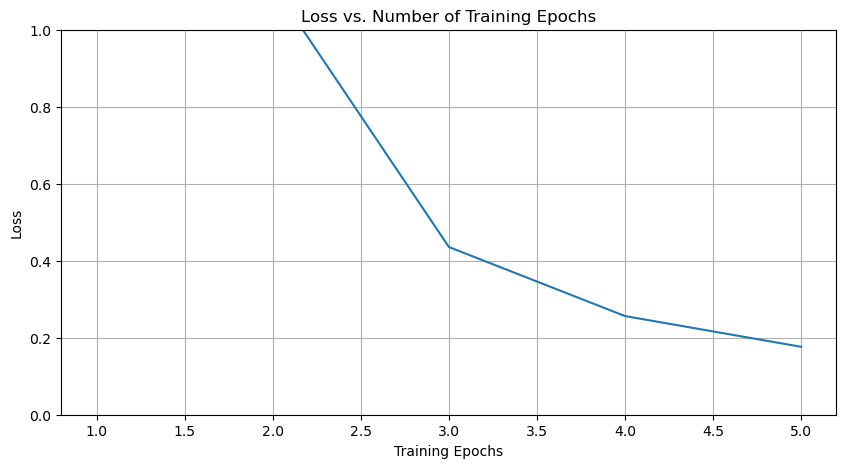

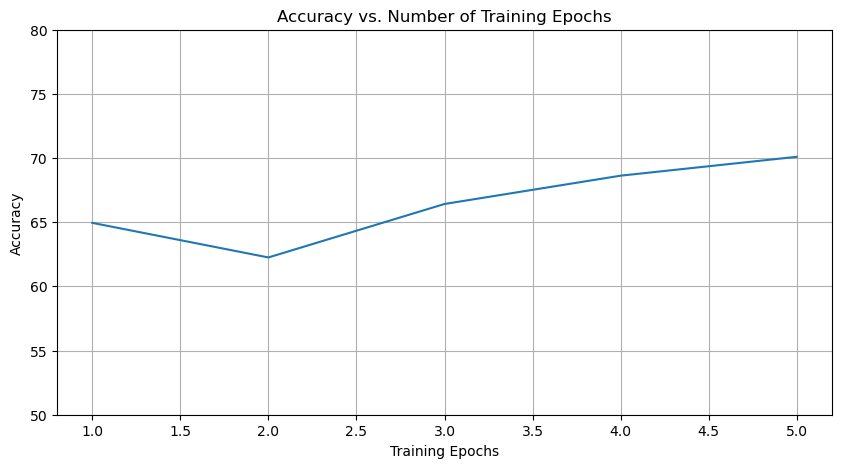

In [11]:
plt.figure(figsize=(10,5))
plt.title("Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, num_epochs + 1), loss_list, label="Training Loss")
plt.grid(True)
plt.ylim(0, 1)
plt.show()

plt.figure(figsize=(10,5))
plt.title("Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1, num_epochs + 1), accuracy_list, label="Validation Accuracy")
plt.grid(True)
plt.ylim(50, 80)
plt.show()

In [12]:
evaluate_model(pretrained, test_loader)

Accuracy: 63.90%


63.90243902439025